In [1]:
import numpy as np
import pandas as pd
import nltk
import warnings
warnings.filterwarnings('ignore')
import gensim
from gensim.models.phrases import Phrases, Phraser
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import gensim.corpora as corpora
import spacy
from nltk.corpus import stopwords
import warnings
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.simplefilter('ignore')

# Data Preparation

In [2]:
# Read in data
truncated_enron_df = pd.read_csv("enron_test.csv")

### 1. Data Sanity Check

In [3]:
truncated_enron_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Date      1000 non-null   object
 1   From      1000 non-null   object
 2   To        995 non-null    object
 3   Subject   698 non-null    object
 4   content   1000 non-null   object
 5   new_date  1000 non-null   object
dtypes: object(6)
memory usage: 47.0+ KB


In [4]:
truncated_enron_df.From = [list(eval(item))[0] for item in truncated_enron_df.From]
truncated_enron_df.To =[list(eval(item))[0] if not pd.isnull(item) else item for item in truncated_enron_df.To]
truncated_enron_df.content = truncated_enron_df.content.apply(lambda x:x.replace("\n\n", " "))

In [5]:
# truncated_enron_df = truncated_enron_df.dropna(subset = ['To'])

In [6]:
truncated_enron_df

,Date,From,To,Subject,content,new_date
0,"Mon, 14 May 2001 16:39:00 -0700 (PDT)",phillip.allen@enron.com,tim.belden@enron.com,NaN,Here is our forecast,2001-05-14 23:39:00
1,"Fri, 4 May 2001 13:51:00 -0700 (PDT)",phillip.allen@enron.com,john.lavorato@enron.com,Re:,Traveling to have a business meeting takes the...,2001-05-04 20:51:00
2,"Wed, 18 Oct 2000 03:00:00 -0700 (PDT)",phillip.allen@enron.com,leah.arsdall@enron.com,Re: test,test successful. way to go!!!,2000-10-18 10:00:00
3,"Mon, 23 Oct 2000 06:13:00 -0700 (PDT)",phillip.allen@enron.com,randall.gay@enron.com,NaN,"Randy, Can you send me a schedule of the sala...",2000-10-23 13:13:00
4,"Thu, 31 Aug 2000 05:07:00 -0700 (PDT)",phillip.allen@enron.com,greg.piper@enron.com,Re: Hello,Let's shoot for Tuesday at 11:45.,2000-08-31 12:07:00
...,...,...,...,...,...,...
995,"Mon, 19 Mar 2001 01:36:00 -0800 (PST)",phillip.allen@enron.com,jacquestc@aol.com,NaN,"Jacques, Still trying to close the loop on the...",2001-03-19 09:36:00
996,"Mon, 19 Mar 2001 00:45:00 -0800 (PST)",phillip.allen@enron.com,llewter@austin.rr.com,Re: Buyout,"Larrry, I realize you are disappointed about t...",2001-03-19 08:45:00
997,"Wed, 6 Dec 2000 08:04:00 -0800 (PST)",phillip.allen@enron.com,pallen70@hotmail.com,NaN,---------------------- Forwarded by Phillip K ...,2000-12-06 16:04:00
998,"Fri, 16 Mar 2001 04:28:00 -0800 (PST)",phillip.allen@enron.com,jacquestc@aol.com,NaN,"Jacques, I think we reached an agreement with ...",2001-03-16 12:28:00


### 2. Text Preprocessing

In [7]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=["NOUN", "ADJ", "VERB", "ADV"]):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [8]:
#Convert sentence to words
content_data = truncated_enron_df.content.values.tolist()
data_words = list(sent_to_words(content_data))

# Build the bigram and trigram models
bigram = Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
# trigram = Phrases(bigram[data_words], threshold=100)

# Get a sentence clubbed as a trigram/bigram
bigram_mod = Phraser(bigram)
# trigram_mod = Phraser(trigram)

# Remove Stop Words
# nltk.download('stopwords')
stop_words = stopwords.words("english")
stop_words.extend(["from", "subject", "re", "edu", "use", "ect", "ECT", "i", "cc", "thank", "sent", "http", "com", "hou", "pm", "am"])
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=["NOUN", "ADJ", "VERB", "ADV"])

# Topic Modeling with LDA

### 1. Build a Baseline LDA

In [9]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)
# Create Corpus
texts = data_lemmatized
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

In [10]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [11]:
# Check a sample topic output
lda_model.print_topics()[0]

(0,
 '0.078*"power" + 0.051*"price" + 0.035*"energy" + 0.033*"market" + 0.032*"gas" + 0.028*"california" + 0.025*"demand" + 0.023*"say" + 0.018*"high" + 0.017*"load"')

### 2. Model performance Metrics

Two metrics are used here for measuring performance of LDA model. The Perplexity measures how well a probablity model predicts a sample. The low the value the better. While the Coherence measures the semantic similarity between high scoring words within a topic, the higher the score the better

In [12]:
#Compute Perplexity Score
print("\nPerplexity: ", lda_model.log_perplexity(corpus))

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print("\nCoherence Score: ", coherence_lda)


Perplexity:  -12.29033557645039

Coherence Score:  0.4784604923700706


### 3.  Select best LDA Model with Grid Search

In [13]:
# Grid search on best topic number
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    perplexity_values = []
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                                id2word=id2word,
                                                num_topics= num_topics,
                                                random_state=100,
                                                update_every=1,
                                                chunksize=100,
                                                passes=10,
                                                alpha='auto',
                                                per_word_topics=True)
        model_list.append(model)
        perplexity = model.log_perplexity(corpus)
        perplexity_values.append(perplexity)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values, perplexity_values

In [14]:
model_list, coherence_values, perplexity_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=2)

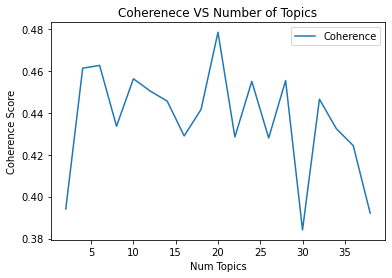

In [15]:
# Show changes of Coherence along with changes of topic numbers
limit=40; start=2; step=2;
x = range(start, limit, step)
plt.plot(x, coherence_values, label = "Coherence")
plt.xlabel("Num Topics")
plt.ylabel("Coherence Score")
plt.title("Coherenece VS Number of Topics")
plt.legend()
plt.show()

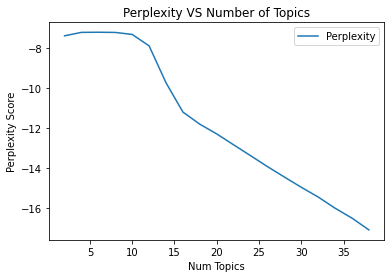

In [16]:
# Show changes of Perplexity along with changes of topic numbers
plt.plot(x, perplexity_values, label = "Perplexity")
plt.xlabel("Num Topics")
plt.ylabel("Perplexity Score")
plt.title("Perplexity VS Number of Topics")
plt.legend()
plt.show()

In [17]:
# print out performance score for each topic number
for m, cv, per in zip(x, coherence_values, perplexity_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4), "has Preplexity", round(per, 4))

Num Topics = 2  has Coherence Value of 0.3941 has Preplexity -7.3878
Num Topics = 4  has Coherence Value of 0.4613 has Preplexity -7.2164
Num Topics = 6  has Coherence Value of 0.4626 has Preplexity -7.2098
Num Topics = 8  has Coherence Value of 0.4336 has Preplexity -7.2193
Num Topics = 10  has Coherence Value of 0.4563 has Preplexity -7.3185
Num Topics = 12  has Coherence Value of 0.4504 has Preplexity -7.8901
Num Topics = 14  has Coherence Value of 0.4456 has Preplexity -9.733
Num Topics = 16  has Coherence Value of 0.429 has Preplexity -11.1975
Num Topics = 18  has Coherence Value of 0.4416 has Preplexity -11.8047
Num Topics = 20  has Coherence Value of 0.4785 has Preplexity -12.2903
Num Topics = 22  has Coherence Value of 0.4285 has Preplexity -12.8349
Num Topics = 24  has Coherence Value of 0.455 has Preplexity -13.3767
Num Topics = 26  has Coherence Value of 0.428 has Preplexity -13.9223
Num Topics = 28  has Coherence Value of 0.4554 has Preplexity -14.444
Num Topics = 30  has C

Since we have limited amount of data to simulate distribution, we value less on model preplexity and mainly look at the coherence score. When topic number = 20 the model has highest coherence score. So in such case the best model is the one we built beofre. 

   ### 4. Visualize the Best model Output: Topics Distinctiveness and Most Salient Words

Use pyLDAvis library to visualize the distinctiveness of the top 20 topic as well as the most significant terms covered in each topic which is more explanable than other visualization such as word clouds. Each bubble represent a topic. The larger the bubble, the higher percentage the number of tweets in the corpus is about the topic. 

In [18]:
pyLDAvis.enable_notebook(sort=True)
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
pyLDAvis.display(vis)

#### Insights
As we can see from the visualiation above, there are 20 topics proposed by the LDA model. As an overall result, words such as "enron", "Power", "Gas", "loan", "energy" are frenquently seen in those emails which make senses because enron was an American energy, commodities and service company. Words such as "loan", "buy", "market", "trade" are frequently seen so we could infer that those emails were sent from trade desk/covers conversations with trade desk. Name of "Pillip Allen" is also on top list which alligns with findings in network analysis -- he is the center of these conversations. 

### 5. Prediction: Use LDA model to segment topics across all documents

In [19]:
def Segment_email_topics(ldamodel=lda_model, corpus=corpus, texts=content_data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row[0], key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Percentage of Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [20]:
df_email_topics = Segment_email_topics(ldamodel=lda_model, corpus=corpus, texts=content_data)
df_email_dominant_topics = df_email_topics.reset_index()
df_email_dominant_topics.columns = ['Document_No', 'Dominant_Topic', 'Topic_Likelihood', 'Keywords_for_Predicted_Topic', 'Email_Content']

In [21]:
df_email_dominant_topics.head(10)

,Document_No,Dominant_Topic,Topic_Likelihood,Keywords_for_Predicted_Topic,Email_Content
0,0,11.0,0.4005,"phillip, allen, forward, enron, mail, pdx, req...",Here is our forecast
1,1,5.0,0.9429,"plant, line, plan, fall, take, company, house,...",Traveling to have a business meeting takes the...
2,2,1.0,0.5022,"change, let, issue, time, list, position, desk...",test successful. way to go!!!
3,3,7.0,0.3724,"basis, kid, map, bruce, stop, print, patti, nw...","Randy, Can you send me a schedule of the sala..."
4,4,1.0,0.2554,"change, let, issue, time, list, position, desk...",Let's shoot for Tuesday at 11:45.
5,5,11.0,0.3470,"phillip, allen, forward, enron, mail, pdx, req...","Greg, How about either next Tuesday or Thursd..."
6,6,11.0,0.4316,"phillip, allen, forward, enron, mail, pdx, req...",Please cc the following distribution list with...
7,7,17.0,0.2442,"morning, full, normal, phillip, else, permissi...",any morning between 10 and 11:30
8,8,11.0,0.7265,"phillip, allen, forward, enron, mail, pdx, req...",1. login: pallen pw: ke9davis I don't think ...
9,9,0.0,0.5480,"power, price, energy, market, gas, california,...",---------------------- Forwarded by Phillip K ...


### 6. Some Further Insights: Find the Most Representative Email Content for Each Topic

In [39]:
# Get most representative document under each topic
df_topic_top_email = pd.DataFrame()
email_by_topic_grp = df_email_topics.groupby('Dominant_Topic')

for i, grp in email_by_topic_grp:
    df_topic_top_email = pd.concat([df_topic_top_email, 
                                    grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                   axis=0)
df_topic_top_email = df_topic_top_email.reset_index()
df_topic_top_email.columns = ['Document_ID','Topic_ID', 'Topic Likelihood', 'Keywords_Contribute_to_Topic', 'Email_Content']
df_topic_top_email.Topic_ID= df_topic_top_email.Topic_ID.astype(int)

In [40]:
df_topic_top_email

,Document_ID,Topic_ID,Topic Likelihood,Keywords_Contribute_to_Topic,Email_Content
0,650,0,0.6279,"power, price, energy, market, gas, california,...","Larry, Just a note to touch base on the sagew..."
1,604,1,0.9734,"change, let, issue, time, list, position, desk...",---------------------- Forwarded by Phillip K ...
2,41,2,0.8612,"project, austin, plan, week, site, property, a...",---------------------- Forwarded by Phillip K ...
3,616,3,0.7103,"trade, gas, index, daily, natural, price, trad...","Liane, As we discussed yesterday, I am concer..."
4,81,4,0.9432,"click, question, www, access, site, web, follo...","Mark, The following is a guest password that ..."
5,1,5,0.9429,"plant, line, plan, fall, take, company, house,...",Traveling to have a business meeting takes the...
6,642,6,0.7983,"socal, notice, mary, detail, short, language, ...","9/8 9/7 diff Socal 36,600 37,200 -600 N..."
7,54,7,0.6944,"basis, kid, map, bruce, stop, print, patti, nw...",why is aeco basis so low on the list? Is NWPL...
8,18,8,0.5613,"approval, rent, approve, study, deposit, let, ...",---------------------- Forwarded by Phillip K ...
9,44,9,0.7655,"buy, yahoo, see, risk, visit, late, good, soon...","Jeff, I need to see the site plan for Burnet...."


#### Insights
Let's take Topic # 1 as an example. In its most representative email, it mentioned about the pricing of trades, which is aligned with the most important keywords in this topics. By combining the key words along with the most representative email content, we could infer that this topic is more related to trading activities.

In [41]:
df_topic_top_email.Email_Content[0]

"Larry,  Just a note to touch base on the sagewood townhomes and other development \nopportunities.  I stumbled across some other duplexes for sale on the same street. that were \nbuilt by Reagan Lehmann.  22 Units were sold for \n around $2 million. ($182,000/duplex).  I spoke to Reagan and he indicated \nthat he had more units under construction that would be \n available in the 180's.  Are the units he is selling significantly different \nfrom yours?  He mentioned some of the units are the 1308 floor\n plan.  My bid of 2.7 million is almost $193,000/duplex.    As far as being an investor in a new project, I am still very interested.    Call or email with your thoughts. Phillip"

### 7. Some Further Insights: Distribution of Emails across All Topics

In [42]:
distribution_across_topic = df_email_topics.groupby(['Dominant_Topic']).agg({'Topic_Keywords':'first',
                                                                             0: 'count'}).reset_index()
distribution_across_topic.columns = ['Topic_ID', 'Top_Keywords', 'Document_Count']
distribution_across_topic['Document_Percentage'] = distribution_across_topic['Document_Count'] / len(df_email_topics) * 100

In [43]:
distribution_across_topic

,Topic_ID,Top_Keywords,Document_Count,Document_Percentage
0,0.0,"power, price, energy, market, gas, california,...",47,4.7
1,1.0,"change, let, issue, time, list, position, desk...",91,9.1
2,2.0,"project, austin, plan, week, site, property, a...",23,2.3
3,3.0,"trade, gas, index, daily, natural, price, trad...",30,3.0
4,4.0,"click, question, www, access, site, web, follo...",37,3.7
5,5.0,"plant, line, plan, fall, take, company, house,...",38,3.8
6,6.0,"socal, notice, mary, detail, short, language, ...",4,0.4
7,7.0,"basis, kid, map, bruce, stop, print, patti, nw...",15,1.5
8,8.0,"approval, rent, approve, study, deposit, let, ...",10,1.0
9,9.0,"buy, yahoo, see, risk, visit, late, good, soon...",28,2.8


#### Insights
As we can see from the table above, topic 11 and topic 13 are topics covered most in those documents. If we trace back to emails tagged as these two topic, we will find that most of them are Enron's internal email to phillip or forwarded by phillip, and mostly covered daily operational stuffs. Those emails take up high percentages in email dataset. Such analysis will help us better understand what are the major popularities in email topic groups.

#### Some insights for further Enhancement:
1. Enhance the model: LDA model has limited capability in case when there're very short email and long email mixed together in dataset. The short email content will cause sparse issue. An atlernative could be BTM model.
2. Bring in more dataset for learning.

# Other Email Topic Modeling Approaches: Email Segmentation with Clustering

#### Note:
Below analysis basically gives you some tastes of how to generally implement an email segementation use case by clustering on emails' content. Please note that due to limited amount of data, the clustering results below didn't really provide very helpful insights. Feature engineering(add more feature) will not be very much helpful in this case as well.
If given more dataset with label, superivsed learning would be always considered as priority.

In [44]:
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

### Method 1. TFI-DF + Word Embedding + Kmeans Clustering

In [45]:
clean_truncated_enron_df = truncated_enron_df.dropna(subset=['To'])

In [46]:
tfidf_vectorizer = TfidfVectorizer(stop_words=stop_words, token_pattern=r'(?u)\b[A-Za-z]+\b') #Remove numbers
ngrams = tfidf_vectorizer.fit_transform(clean_truncated_enron_df.content)

In [47]:
# Each document find top 20 words with highest TFIDF score
feature_array = np.array(tfidf_vectorizer.get_feature_names())
tfidf_sorting = np.argsort(ngrams.toarray())
n = 20
top_n_list = []
for tfidf_sorted in tfidf_sorting:
    top_n = list(feature_array[tfidf_sorted[-n:][::-1]])
    top_n_list.append(top_n)

In [48]:
# Use pre-trained word2vec to map words into 300 dim-numerical vector
# Load pre-train word2vec
model = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
# Map words into word2vec features
tfidf_doc_embedding_list = []
for top_n in top_n_list:
    embeding_vec = np.zeros(300)
    for word in top_n:
        if word in model:
            embeding_vec += model[word]
    tfidf_doc_embedding_list.append(embeding_vec)

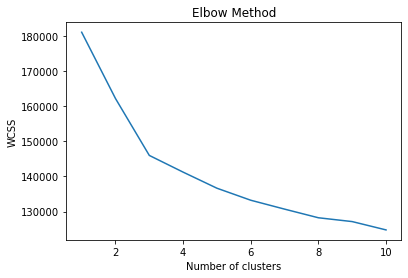

In [49]:
# Find optimal K to cluster
X = np.array(tfidf_doc_embedding_list)
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [50]:
kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=300, n_init=10, random_state=0)
pred_y = kmeans.fit_predict(X)
clean_truncated_enron_df['kmeans_pred'] = pred_y

In [51]:
clean_truncated_enron_df.head()

,Date,From,To,Subject,content,new_date,kmeans_pred
0,"Mon, 14 May 2001 16:39:00 -0700 (PDT)",phillip.allen@enron.com,tim.belden@enron.com,NaN,Here is our forecast,2001-05-14 23:39:00,0
1,"Fri, 4 May 2001 13:51:00 -0700 (PDT)",phillip.allen@enron.com,john.lavorato@enron.com,Re:,Traveling to have a business meeting takes the...,2001-05-04 20:51:00,1
2,"Wed, 18 Oct 2000 03:00:00 -0700 (PDT)",phillip.allen@enron.com,leah.arsdall@enron.com,Re: test,test successful. way to go!!!,2000-10-18 10:00:00,0
3,"Mon, 23 Oct 2000 06:13:00 -0700 (PDT)",phillip.allen@enron.com,randall.gay@enron.com,NaN,"Randy, Can you send me a schedule of the sala...",2000-10-23 13:13:00,1
4,"Thu, 31 Aug 2000 05:07:00 -0700 (PDT)",phillip.allen@enron.com,greg.piper@enron.com,Re: Hello,Let's shoot for Tuesday at 11:45.,2000-08-31 12:07:00,0


In [52]:
# Get top word features for each cluster
def get_top_features_cluster(tf_idf_array, prediction, n_feats):
    labels = np.unique(prediction)
    dfs = []
    for label in labels:
        id_temp = np.where(prediction==label) # indices for each cluster
        x_means = np.mean(tf_idf_array[id_temp], axis = 0) # returns average score across cluster
        sorted_means = np.argsort(x_means)[::-1][:n_feats] # indices with top 20 scores
        features = tfidf_vectorizer.get_feature_names()
        best_features = [(features[i], x_means[i]) for i in sorted_means]
        df = pd.DataFrame(best_features, columns = ['features', 'score'])
        dfs.append(df)
    return dfs
dfs = get_top_features_cluster(ngrams.toarray(), pred_y, 15)

In [53]:
dfs

[    features     score
 0    phillip  0.049910
 1     please  0.029563
 2     thanks  0.022627
 3      allen  0.017915
 4      email  0.016893
 5      still  0.016763
 6       call  0.016310
 7       file  0.016234
 8       west  0.016100
 9   received  0.015582
 10      send  0.015542
 11         k  0.014579
 12       get  0.014392
 13      good  0.014125
 14       try  0.013613,
    features     score
 0   phillip  0.037701
 1     would  0.035258
 2     enron  0.025650
 3      need  0.024751
 4       gas  0.024171
 5     allen  0.021600
 6      like  0.020362
 7   project  0.019714
 8       get  0.019362
 9      know  0.018823
 10     work  0.018696
 11    email  0.018338
 12      let  0.017972
 13     call  0.017949
 14     week  0.017855,
      features     score
 0       enron  0.139360
 1       allen  0.086209
 2           k  0.082025
 3     phillip  0.073296
 4   forwarded  0.045328
 5        corp  0.041191
 6          na  0.033617
 7     meeting  0.029548
 8      please  0.028

### Method 2. TFI-DF + PCA + Kmeans Clustering

In [54]:
X_dense = ngrams.todense()

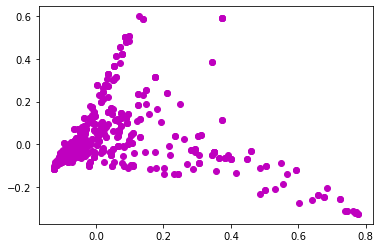

In [55]:
# Dimension Reduction on TF-IDFed features
coords = PCA(n_components=2).fit_transform(X_dense)
plt.scatter(coords[:, 0], coords[:, 1], c='m')
plt.show()

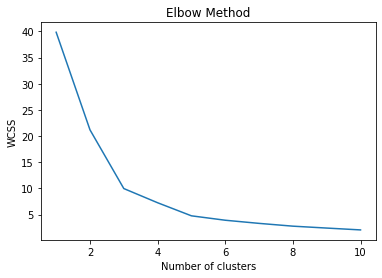

In [56]:
# Find best K 
X = coords
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [57]:
PCA_kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=300, n_init=10, random_state=0)
PCA_pred_y = PCA_kmeans.fit_predict(coords)

In [58]:
PCA_dfs = get_top_features_cluster(ngrams.toarray(), PCA_pred_y, 15)

In [59]:
#Get top features for each cluster
PCA_dfs

[   features     score
 0   phillip  0.040105
 1    please  0.023643
 2     would  0.022513
 3     email  0.018436
 4       get  0.017967
 5      need  0.017618
 6      call  0.016654
 7     allen  0.016075
 8       gas  0.016007
 9      lucy  0.015152
 10    enron  0.014527
 11      let  0.013958
 12      new  0.012931
 13   thanks  0.012911
 14     west  0.012838,
        features     score
 0             k  0.188304
 1         allen  0.180552
 2       phillip  0.133939
 3     forwarded  0.093022
 4       meeting  0.053319
 5           tim  0.051292
 6         enron  0.050415
 7        hunter  0.042166
 8       shively  0.041459
 9           pdx  0.036031
 10     attached  0.034998
 11  heizenrader  0.033409
 12     strategy  0.031762
 13        scott  0.027820
 14          gas  0.027702,
      features     score
 0       enron  0.432927
 1          na  0.135841
 2        corp  0.125630
 3         ees  0.067580
 4     request  0.065025
 5           k  0.053409
 6       allen  0.05310

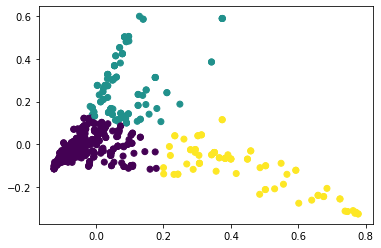

In [60]:
coords = PCA(n_components=2).fit_transform(X_dense)
plt.scatter(coords[:, 0], coords[:, 1], c=PCA_pred_y)
plt.show()